App v0.1

# A/B Testing Analysis Report

## 1 - Packages

- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- `model` provides the functions implemented in the batch training process.
- `np.random.seed(1)` is used to keep all the random function calls consistent. It will help us grade your work.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from model import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Dataset: Cat vs. Non-Cat
**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

### 2.1 - Dataset Exploration

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

**Random Example Image:**

y = 1. It's a cat picture.


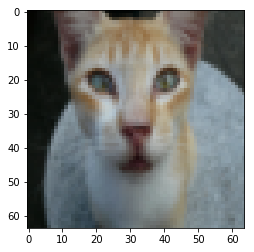

In [3]:
# Example of a picture
index = 11
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


### 2.2 - Dataset Preprocessing

In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 3 - Model A: Architecture

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

In [6]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 1
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
### Two Layer Model ###
def two_layer_model(X, Y, layers_dims, learning_rate = 0.002, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID.
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation.
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters using Gradient Descent
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### 3.1 Model A: Training Results

Cost after iteration 0: 0.6941101134647648
Cost after iteration 100: 0.6882644046953941
Cost after iteration 200: 0.6809386136495165
Cost after iteration 300: 0.6618917951827955
Cost after iteration 400: 0.6489804586987876
Cost after iteration 500: 0.6462739402199474
Cost after iteration 600: 0.6438657232891971
Cost after iteration 700: 0.6409886932434056
Cost after iteration 800: 0.6373798446957976
Cost after iteration 900: 0.6327366714811535
Cost after iteration 1000: 0.6266885269068938
Cost after iteration 1100: 0.6190660558863323
Cost after iteration 1200: 0.6102065728825855
Cost after iteration 1300: 0.6006637069200073
Cost after iteration 1400: 0.5902994536930722
Cost after iteration 1500: 0.579645939205918
Cost after iteration 1600: 0.5684501421146996
Cost after iteration 1700: 0.5568577354413902
Cost after iteration 1800: 0.5457314048578485
Cost after iteration 1900: 0.5340984640235206
Cost after iteration 2000: 0.52249315250677
Cost after iteration 2100: 0.5108959545034146
Cos

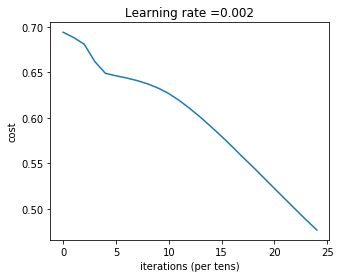

In [8]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Training Dataset Accuracy**

In [9]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.655502392344


<table> 
    <tr>
        <td> **Preferred Accuracy:**</td>
        <td> 0.98 </td>
    </tr>
</table>

**Validation Dataeet Accuracy**

In [10]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.34


<table> 
    <tr>
        <td> **Preferred Accuracy:**</td>
        <td> 0.75 </td>
    </tr>
</table>

## 4 - Model B: Architecture

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

In [11]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

In [12]:
### L_layer_model ###
def L_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### 4.1 Model A: Training Results

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.668643
Cost after iteration 200: 0.644902
Cost after iteration 300: 0.585219
Cost after iteration 400: 0.521544
Cost after iteration 500: 0.490371
Cost after iteration 600: 0.388918
Cost after iteration 700: 0.366900
Cost after iteration 800: 0.398332
Cost after iteration 900: 0.351117
Cost after iteration 1000: 0.250425
Cost after iteration 1100: 0.167711
Cost after iteration 1200: 0.143310
Cost after iteration 1300: 0.125508
Cost after iteration 1400: 0.111445
Cost after iteration 1500: 0.100332
Cost after iteration 1600: 0.091003
Cost after iteration 1700: 0.082590
Cost after iteration 1800: 0.075972
Cost after iteration 1900: 0.071135
Cost after iteration 2000: 0.065827
Cost after iteration 2100: 0.063602
Cost after iteration 2200: 0.057674
Cost after iteration 2300: 0.054198
Cost after iteration 2400: 0.051434


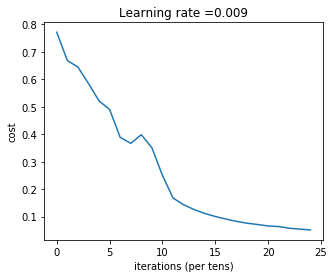

In [13]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Training Dataset Accuracy**

In [14]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.995215311005


<table>
    <tr>
    <td>
    **Preferred Accuracy**
    </td>
    <td>
    0.98
    </td>
    </tr>
</table>

In [15]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


<table> 
    <tr>
        <td> **Preferred Accuracy**</td>
        <td> 0.75 </td>
    </tr>
</table>

## 5 -  Conclusion
**Mislabeled Images**

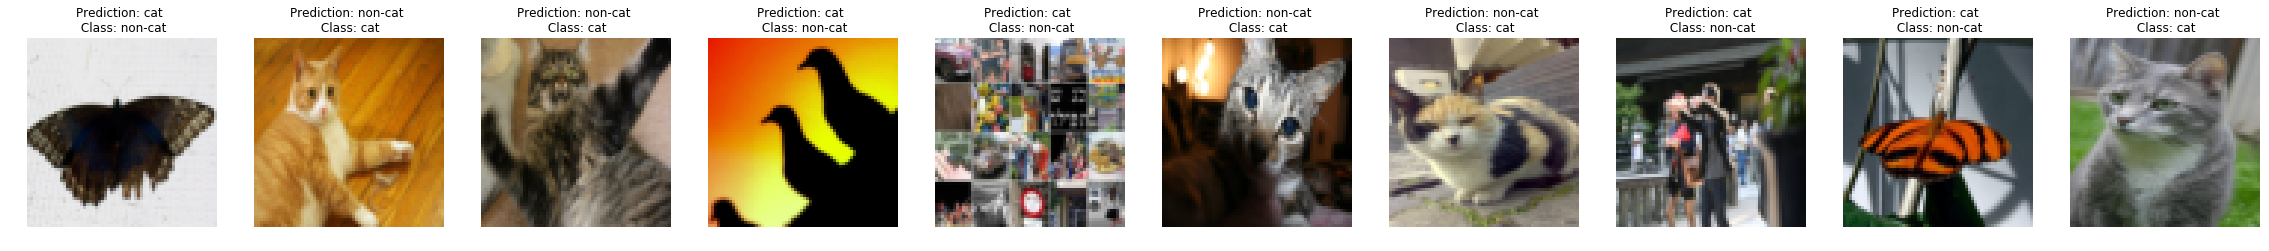

In [16]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few type of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

In [17]:
# Save Optimized Parameters
with h5py.File('params.h5', 'w') as h5file:
    for key in parameters:
        h5file['/' + key] = parameters[key]    

---
## Appendix A: Verify Optimized Parameters

In [18]:
# Open parameters file
with h5py.File('params.h5', 'r') as h5file:
    ans = {}
    for key, item in h5file['/'].items():
        ans[key] = item.value

In [19]:
test = parameters['W1']
to_test = ans['W1']

In [20]:
assert test.all() == to_test.all()

In [21]:
ans['W1'].shape

(20, 12288)

In [22]:
parameters['W1'].shape

(20, 12288)

---
## Appendix B: API Testing

In [23]:
# Open parameters file
with h5py.File('params.h5', 'r') as h5file:
    parameters = {}
    for key, item in h5file['/'].items():
        parameters[key] = item.value

In [24]:
from skimage import transform
my_image = "my_image.jpg" # change this to the name of your image file 
y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
fname = "images/" + my_image
#image = np.array(ndimage.imread(fname, flatten=False))
image = plt.imread(fname)#, flatten=False)
#my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
image = transform.resize(image, (num_px, num_px), mode='constant').reshape((num_px * num_px * 3, 1))

In [25]:
Y_pred = predict(image, y, parameters)

Accuracy: 1.0


In [26]:
classes = ("non-cat", "cat")

In [27]:
output = str(classes[int(np.squeeze(Y_pred))])
output

'cat'